In [22]:
from typing import Tuple, Optional, List, Callable

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import frame_whitening as fw
import frame_whitening.plot as fwplt
from frame_whitening import stats
from frame_whitening import types


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


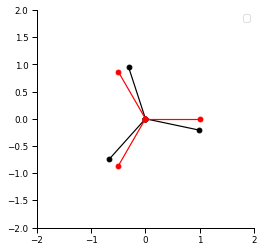

In [42]:
np.random.seed(0)
W = fw.get_mercedes_frame()
A = np.linalg.qr(np.random.randn(2, 2))[0]

with sns.plotting_context("paper"):
    fig, ax = plt.subplots(1, 1)
    fwplt.plot_frame2d(A@W, ax=ax, color='k')
    fwplt.plot_frame2d(W, ax=ax, color='r')
    ax.axis("square")
    ax.set(xlim=(-2, 2), ylim=(-2, 2))
    ax.legend()
    sns.despine()

In [28]:
from functools import partial
_, get_dg = fw.simulation.get_opt_funcs(types.FuncType.POWER)


def _get_y_pow_asymmetric_feedforward(
    g: npt.NDArray[np.float64],
    W: npt.NDArray[np.float64],
    x: npt.NDArray[np.float64],
    A: npt.NDArray[np.float64],
    alpha: float = 0,
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """Compute steady-state y for a given x and g and alpha.
    With asymmetric feeforward weights.
    f(g) = g^{alpha+1}
    """
    G = np.diag(g ** (alpha + 1))
    y = A @ np.linalg.inv(W @ G @ W.T) @ x
    return y, G

def _get_y_pow_asymmetric_feedback(
    g: npt.NDArray[np.float64],
    W: npt.NDArray[np.float64],
    x: npt.NDArray[np.float64],
    A: npt.NDArray[np.float64],
    alpha: float = 0,
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """Compute steady-state y for a given x and g and alpha.
    With asymmetric feedback weights.
    f(g) = g^{alpha+1}
    """
    G = np.diag(g ** (alpha + 1))
    y =  np.linalg.inv(W @ G @ W.T) @ A @ x
    return y, G

In [43]:
def simulate(
    cholesky_list: List[npt.NDArray[np.float64]],
    W: npt.NDArray[np.float64],
    get_y: Callable[..., Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]],
    get_dg: Callable[..., npt.NDArray[np.float64]],
    batch_size: int = 64,
    n_batch: int = 1024,
    lr_g: float = 5e-3,
    g0: Optional[npt.NDArray[np.float64]] = None,
    seed: Optional[float] = None,
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """Simulate data from a given model. """
    if seed is not None:
        np.random.seed(seed)

    # initialize random set of gains g
    N, K = W.shape
    g = g0 if g0 is not None else np.ones(K)

    g_all = []
    g_last = []
    errors = []
    responses = []

    # run simulation with minibatches
    Ixx = np.eye(N)
    for Lxx in cholesky_list:
        Cxx = Lxx @ Lxx.T
        for _ in range(n_batch):
            x = stats.sample_x(Lxx, batch_size)  # draw a sample of x

            y, G = get_y(g, W, x)
            M = np.linalg.inv(W @ G @ W.T)
            error = np.trace(np.abs(M @ Cxx @ M.T - Ixx)) / N
            errors.append(error)

            dg = get_dg(g, W, y)
            g = g - lr_g * dg  # gradient descent
            z = W.T @ y
            responses.append((x.mean(-1), y.mean(-1), z.mean(-1)))
            g_all.append(g)
        g_last.append(g)

    g_last = np.stack(g_last, 0)
    g_all = np.stack(g_all, 0)
    return g_last, g_all, errors  # type: ignore


In [54]:
seed = 42069
np.random.seed(seed)
batch_size = 256
n_batch = 10000
lr_g = 5e-3
n = 2

Q = fw.rot2(np.deg2rad(35))
kappa = 8
Cxx0 = Q @ np.diag([kappa, 1]) @ Q.T * 1 / (np.sqrt(kappa))

cholesky_list = [np.linalg.cholesky(C) for C in [Cxx0]]
W = fw.get_mercedes_frame()
N, K = W.shape

g_opt = fw.compute_g_opt(sp.linalg.fractional_matrix_power(Cxx0, .5), W)

In [55]:
alpha = 0.
_, _get_dg_pow = fw.simulation.get_opt_funcs(types.FuncType.POWER)

g0 = fw.simulation.init_g_const(0.1, 3, types.FuncType.POWER, alpha=alpha)
g_last, g_all, errors = fw.simulation.simulate(
    cholesky_list,
    W,
    partial(_get_y_pow_asymmetric_feedforward, A=A, alpha=alpha),
    partial(_get_dg_pow, alpha=alpha),
    batch_size,
    n_batch,
    lr_g,
    g0=g0,
    seed=seed,
)

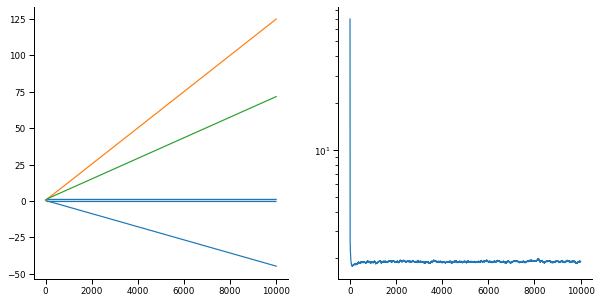

In [56]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].hlines(g_opt, 0, n_batch)
    ax[0].plot(g_all)

    ax[1].plot(errors)
    ax[1].set(yscale="log")
    sns.despine()